In [1]:
import pandas as pd
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

df = pd.read_csv('./data/classify_data.csv')
# df.drop(['season', 'day_time', 'weekday_index', 'weekend'], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361346 entries, 0 to 361345
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   score          361346 non-null  float64
 1   hashtag        361346 non-null  object 
 2   lang           361346 non-null  object 
 3   tweet_lang     361346 non-null  object 
 4   time_zone      361346 non-null  object 
 5   month          361346 non-null  int64  
 6   hours          361346 non-null  int64  
 7   track_id       361346 non-null  object 
 8   season         361346 non-null  int64  
 9   day_time       361346 non-null  object 
 10  weekday_index  361346 non-null  int64  
 11  weekend        361346 non-null  bool   
dtypes: bool(1), float64(1), int64(4), object(6)
memory usage: 30.7+ MB


In [2]:
# track_to_label = pd.read_csv('./data/track_to_labels_dbscan.csv')
track_to_label = pd.read_csv('./data/track_to_labels_kmeans_5.csv')
track_to_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26911 entries, 0 to 26910
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   track_id  26911 non-null  object
 1   labels    26911 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 420.6+ KB


In [3]:
df = df.merge(track_to_label, on='track_id', how='left')
df.head()

,score,hashtag,lang,tweet_lang,time_zone,month,hours,track_id,season,day_time,weekday_index,weekend,labels
0,0.8,kiss92,en,en,Beijing,1,5,3Px454rzMHtIRc9R04QSlB,0,Wee hours(00:00 - 6:00),2,False,1
1,0.8,kiss92,en,en,Beijing,1,6,5eaD4UEbmcXZe0buNHOM64,0,Morning(6:00 - 12:00),2,False,2
2,0.8,kiss92,en,en,Beijing,1,6,75VOiyc0bT0VkFFQuKakgE,0,Morning(6:00 - 12:00),2,False,3
3,0.8,kiss92,en,en,Beijing,1,6,0Dy1Q2uUKII4asOHvexBn9,0,Morning(6:00 - 12:00),2,False,1
4,0.8,kiss92,en,en,Beijing,1,6,777VRhgQZ1L2c0RJnLlNI9,0,Morning(6:00 - 12:00),2,False,0


In [4]:
df = df.dropna()
df.labels.value_counts()

1    120672
2     73321
3     69621
0     63805
4     33927
Name: labels, dtype: int64

In [5]:
# 去除离群点
df = df[df['labels'] != -1]
df.labels.value_counts()

1    120672
2     73321
3     69621
0     63805
4     33927
Name: labels, dtype: int64

In [5]:
# # 创建交叉组合特征
# df['month_day_time'] = df['month'].astype(str) + '_' + df['day_time']
# df['day_time_hours'] = df['day_time'] + '_' + df['hours'].astype(str)

# 对分数score取平方、3次方
df['score_2'] = df['score'] ** 2
df['score_3'] = df['score'] ** 3

# 对情绪分数score进行分箱操作
labels = ['抑郁', '悲伤', '平静', '开心', '兴奋']
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
df['mood'] = pd.cut(df['score'], labels=labels, bins = bins, include_lowest=True)
df['mood_label'] = df['mood'].cat.codes

bins = [0.0, 0.5, 1.0]
df['happy'] = pd.cut(df['score'], labels=[0, 1], bins = bins, include_lowest=True)

df.to_csv('./data/final_classify_data.csv', index = False)

track_id = df.drop(['mood'], inplace=True, axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361346 entries, 0 to 361345
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   score          361346 non-null  float64 
 1   hashtag        361346 non-null  object  
 2   lang           361346 non-null  object  
 3   tweet_lang     361346 non-null  object  
 4   time_zone      361346 non-null  object  
 5   month          361346 non-null  int64   
 6   hours          361346 non-null  int64   
 7   track_id       361346 non-null  object  
 8   season         361346 non-null  int64   
 9   day_time       361346 non-null  object  
 10  weekday_index  361346 non-null  int64   
 11  weekend        361346 non-null  bool    
 12  labels         361346 non-null  int64   
 13  score_2        361346 non-null  float64 
 14  score_3        361346 non-null  float64 
 15  mood_label     361346 non-null  int8    
 16  happy          361346 non-null  category
dtypes: bool(1)

In [4]:
# 对几个类别特别多的列采用二进制编码
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder

# # 二进制编码
# columns = ['hashtag', 'tweet_lang', 'time_zone', 'lang', 'month_day_time', 'day_time_hours']

# 不交叉组合
columns = ['hashtag', 'tweet_lang', 'time_zone', 'lang']

# # 特征衍生
columns += ['day_time']
for column in columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])

print(df.info())
# 查看结果

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361346 entries, 0 to 361345
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   score          361346 non-null  float64
 1   hashtag        361346 non-null  int64  
 2   lang           361346 non-null  int64  
 3   tweet_lang     361346 non-null  int64  
 4   time_zone      361346 non-null  int64  
 5   month          361346 non-null  int64  
 6   hours          361346 non-null  int64  
 7   track_id       361346 non-null  object 
 8   season         361346 non-null  int64  
 9   day_time       361346 non-null  int64  
 10  weekday_index  361346 non-null  int64  
 11  weekend        361346 non-null  bool   
 12  labels         361346 non-null  int64  
dtypes: bool(1), float64(1), int64(10), object(1)
memory usage: 36.2+ MB
None


In [5]:

X = df.drop(['labels', 'track_id'], axis = 1)
y = df['labels']
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361346 entries, 0 to 361345
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   score          361346 non-null  float64
 1   hashtag        361346 non-null  int64  
 2   lang           361346 non-null  int64  
 3   tweet_lang     361346 non-null  int64  
 4   time_zone      361346 non-null  int64  
 5   month          361346 non-null  int64  
 6   hours          361346 non-null  int64  
 7   season         361346 non-null  int64  
 8   day_time       361346 non-null  int64  
 9   weekday_index  361346 non-null  int64  
 10  weekend        361346 non-null  bool   
dtypes: bool(1), float64(1), int64(9)
memory usage: 30.7 MB
None


In [12]:
from imblearn.over_sampling import SMOTENC

categorical_features = [1, 2, 3, 4]
# 衍生特征后
# categorical_features += [10, 13, 14]

smote_nc = SMOTENC(categorical_features = categorical_features, random_state=42)
# 应用 SMOTENC 到你的数据
X_resampled, y_resampled = smote_nc.fit_resample(X, y)
print(X_resampled)
print((y_resampled == 0).sum(), (y_resampled == 1).sum())

           score  hashtag  lang  tweet_lang  time_zone  month  hours
0       0.800000     1598     5           5         17      1      5
1       0.800000     1598     5           5         17      1      6
2       0.800000     1598     5           5         17      1      6
3       0.800000     1598     5           5         17      1      6
4       0.800000     1598     5           5         17      1      6
...          ...      ...   ...         ...        ...    ...    ...
387397  0.675000     2076     4           5          8      7      4
387398  0.221875      695     5           5         84     11     17
387399  0.221875      695     5           5         84     11     10
387400  0.323437     1584     5           5         84      7      8
387401  0.000000     2274     5           5         34     12     20

[387402 rows x 7 columns]
193701 193701


In [32]:
# X_resampled.to_csv('./data/X_encoder_resampled_dbscan.csv', index = False)
# y_resampled.to_csv('./data/y_encoder_resampled_dbscan.csv', index = False)

# X_resampled.to_csv('./data/X_encoder_resampled_kmeans.csv', index = False)
# y_resampled.to_csv('./data/y_encoder_resampled_kmeans.csv', index = False)

X_resampled.to_csv('./data/X_feature_resampled_kmeans_5.csv', index = False)
y_resampled.to_csv('./data/y_feature_resampled_kmeans_5.csv', index = False)

In [1]:
import pandas as pd
# X_resampled = pd.read_csv('./data/X_feature_resampled_dbscan.csv')
# y_resampled = pd.read_csv('./data/y_feature_resampled_dbscan.csv')

# X_resampled = pd.read_csv('./data/X_encoder_resampled_kmeans.csv')
# y_resampled = pd.read_csv('./data/y_encoder_resampled_kmeans.csv')
X_resampled = pd.read_csv('./data/X_feature_resampled_kmeans.csv')
y_resampled = pd.read_csv('./data/y_feature_resampled_kmeans.csv', dtype = 'float32')

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_resampled_norm = MinMaxScaler().fit_transform(X)
X_resampled_norm

X_resampled_norm_and_one = StandardScaler().fit_transform(X_resampled_norm)
X_resampled_norm_and_one

array([[ 0.90456012, -0.43526774, -0.50107684, ...,  1.35281341,
        -0.49139898, -0.63524067],
       [ 0.90456012, -0.43526774, -0.50107684, ..., -0.44661865,
        -0.49139898, -0.63524067],
       [ 0.90456012, -0.43526774, -0.50107684, ..., -0.44661865,
        -0.49139898, -0.63524067],
       ...,
       [-0.74829412, -1.73401162, -0.50107684, ...,  1.35281341,
        -0.9876791 , -0.63524067],
       [-0.74829412, -1.92419573, -0.50107684, ...,  1.35281341,
        -0.9876791 , -0.63524067],
       [-0.74829412, -1.68010917, -0.50107684, ..., -0.44661865,
        -0.9876791 , -0.63524067]])

In [7]:
y = np.array(y)
print(X_resampled_norm_and_one, '\n', y)

[[ 0.90456012 -0.43526774 -0.50107684 ...  1.35281341 -0.49139898
  -0.63524067]
 [ 0.90456012 -0.43526774 -0.50107684 ... -0.44661865 -0.49139898
  -0.63524067]
 [ 0.90456012 -0.43526774 -0.50107684 ... -0.44661865 -0.49139898
  -0.63524067]
 ...
 [-0.74829412 -1.73401162 -0.50107684 ...  1.35281341 -0.9876791
  -0.63524067]
 [-0.74829412 -1.92419573 -0.50107684 ...  1.35281341 -0.9876791
  -0.63524067]
 [-0.74829412 -1.68010917 -0.50107684 ... -0.44661865 -0.9876791
  -0.63524067]] 
 [1 2 3 ... 3 0 2]


In [12]:
print(X.shape)

(273379, 11)


### 分类
#### 常用机器学习模型

In [11]:

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
import time
from sklearn.utils.class_weight import compute_class_weight    

# 降维
n_components = np.arange(2, 8)

# 假设你有五个类别，其中某些类别的样本量远少于其他
classes = np.array([0, 1, 2, 3, 4])
class_weights = compute_class_weight('balanced', classes=classes, y=y)
weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(weight_dict)

# 定义模型
models = {
    'LogisticRegression': LogisticRegression(C=0.1, max_iter=5000, class_weight=weight_dict),
    'LightGBM': lgb.LGBMClassifier(n_estimators=10, random_state=42, force_row_wise=True,  class_weight=weight_dict),
    'RandomForest': RandomForestClassifier(n_estimators=10, random_state=42,  class_weight=weight_dict)
}

# # 定义模型
# models = {
#     'LogisticRegression': LogisticRegression(C=0.1, max_iter=5000),
#     'LightGBM': lgb.LGBMClassifier(n_estimators=10, random_state=42, force_row_wise=True),
#     'RandomForest': RandomForestClassifier(n_estimators=10, random_state=42)
# }

scores = {}
for name, model in models.items():
    for n_component in n_components:
        X_pca = PCA(n_components = n_component).fit_transform(X_resampled_norm_and_one, y)
        X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f'{name} y_pred 0 的个数为 为{(y_pred == 0).sum()}, 1的个数为{(y_pred == 1).sum()},2的个数为：{(y_pred == 2).sum()}, 3的个数为:{(y_pred == 3).sum()}, 4的个数为：{(y_pred==4).sum()}')
        accuracy = accuracy_score(y_test, y_pred)
        print(f'{name} 降维为{n_component}的准确率为{accuracy}')
        if name not in scores:
            scores[name] = []
        scores[name].append(accuracy)

{0: 1.1326573152574249, 1: 0.5988895518430125, 2: 0.9856548601355682, 3: 1.0380373737808994, 4: 2.1301382379815488}
LogisticRegression y_pred 0 的个数为 为22489, 1的个数为14374,2的个数为：4251, 3的个数为:0, 4的个数为：31156
LogisticRegression 降维为2的准确率为0.17579908675799086
LogisticRegression y_pred 0 的个数为 为9713, 1的个数为22861,2的个数为：9512, 3的个数为:0, 4的个数为：30184
LogisticRegression 降维为3的准确率为0.20011069600110695
LogisticRegression y_pred 0 的个数为 为8654, 1的个数为23116,2的个数为：9227, 3的个数为:867, 4的个数为：30406
LogisticRegression 降维为4的准确率为0.19872699598726995
LogisticRegression y_pred 0 的个数为 为9200, 1的个数为24488,2的个数为：7121, 3的个数为:3035, 4的个数为：28426
LogisticRegression 降维为5的准确率为0.20563165905631658
LogisticRegression y_pred 0 的个数为 为11342, 1的个数为18037,2的个数为：19687, 3的个数为:1890, 4的个数为：21314
LogisticRegression 降维为6的准确率为0.21520686315206863
LogisticRegression y_pred 0 的个数为 为13803, 1的个数为12757,2的个数为：18103, 3的个数为:3312, 4的个数为：24295
LogisticRegression 降维为7的准确率为0.20354227203542272
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in 

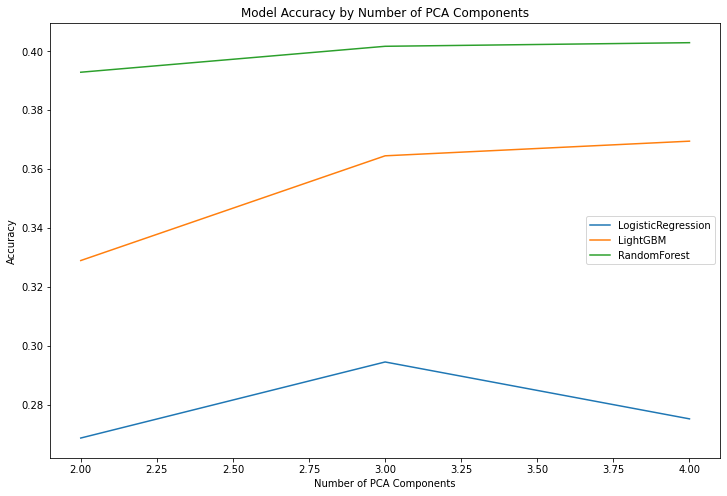

In [19]:
import matplotlib.pyplot as plt
# 创建图和轴
fig, ax = plt.subplots(figsize=(12, 8))

# 循环遍历scores字典中的每个模型，绘制其准确率折线图
for model_name, accuracies in scores.items():
    ax.plot(n_components, accuracies, label=model_name)

# 设置图例
ax.legend()

# 添加标题和轴标签
ax.set_title('Model Accuracy by Number of PCA Components')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Accuracy')

# 显示图形
plt.show()

In [15]:
# 因此降为7维进行交叉验证
from sklearn.decomposition import PCA

X_pca = PCA(n_components = 9).fit_transform(X_resampled_norm_and_one)

In [20]:
# LDA降维
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
X_lda = LDA(n_components = 3).fit_transform(X_resampled_norm_and_one, y)

In [21]:
X_lda

array([[-1.24447352, -0.80479215,  0.36757537],
       [-1.29560332, -0.76315272,  0.1196835 ],
       [-1.29560332, -0.76315272,  0.1196835 ],
       ...,
       [ 0.3965375 , -0.91011396,  2.0867959 ],
       [ 1.38224378,  0.12692126,  1.5316858 ],
       [ 1.04377005, -0.34113627,  1.84456733]])

In [18]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, LogisticRegression
import time
from sklearn.utils.class_weight import compute_class_weight 

# 定义模型

# # 有五个类别，其中某些类别的样本量远少于其他
# classes = np.array([0, 1, 2, 3, 4])
# class_weights = compute_class_weight('balanced', classes=classes, y=y)
# weight_dict = {i: weight for i, weight in enumerate(class_weights)}
# print(weight_dict)

# models = {
#     'LogisticRegression': LogisticRegression(C=0.1, max_iter=10000, class_weight=weight_dict),
#     'LightGBM': lgb.LGBMClassifier(n_estimators=10, random_state=42, force_row_wise=True,  class_weight=weight_dict),
#     'RandomForest': RandomForestClassifier(n_estimators=10, random_state=42,  class_weight=weight_dict)
# }

models = {
    'LogisticRegression': LogisticRegression(C=0.1, max_iter=10000),
    'LightGBM': lgb.LGBMClassifier(n_estimators=10, random_state=42, force_row_wise=True),
    'RandomForest': RandomForestClassifier(n_estimators=10, random_state=42)
}

## 去除噪声，平衡样本，32 33 （未衍生）
## 去除噪声，未平衡样本，41、43、43 （这里预测值有偏向）

# 定义评估指标
num_classes = len(set(y))
print(num_classes)

scoring = []
if num_classes == 2:
    scoring = ['accuracy', 'precision', 'recall', 'f1']
elif num_classes > 2:
    scoring = ['accuracy', 'f1_micro', 'f1_macro', 'f1_weighted']
else:
    print(f'Error num_classes of {num_classes}')

# 使用Stratified K-Fold进行交叉验证
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 训练模型并评估
results = {name: [] for name in models}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    start_time = time.time()
    for score_name in scoring:
        score = cross_val_score(model, X_resampled_norm_and_one, y, scoring=score_name, cv=cv, n_jobs=-1)
        results[model_name].append((score.mean(), score.std()))
    end_time = time.time()
    print(f'{model_name}运行时间为：{end_time - start_time}')

# 输出结果
for model_name, model_scores in results.items():
    print(f"\nResults for {model_name}:")
    for i, score_name in enumerate(scoring):
        mean, std = model_scores[i]
        print(f"{score_name}: {100 * mean:.2f}±{100 * std:.2f}")

5
Evaluating LogisticRegression...
LogisticRegression运行时间为：6.624477386474609
Evaluating LightGBM...
LightGBM运行时间为：1175.550142288208
Evaluating RandomForest...
RandomForest运行时间为：12.26126742362976

Results for LogisticRegression:
accuracy: 41.07±0.07
f1_micro: 41.07±0.07
f1_macro: 13.83±0.11
f1_weighted: 25.79±0.10

Results for LightGBM:
accuracy: 43.68±0.09
f1_micro: 43.68±0.09
f1_macro: 21.98±0.17
f1_weighted: 32.16±0.14

Results for RandomForest:
accuracy: 43.59±0.21
f1_micro: 43.59±0.21
f1_macro: 31.24±0.34
f1_weighted: 39.37±0.24


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 参数网格
param_grid_lr = {
    'C': [1],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# 创建模型
logistic_model = LogisticRegression(max_iter=5000)

# 创建 GridSearchCV 对象
grid_search_lr = GridSearchCV(estimator=logistic_model, param_grid=param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# 加载数据
grid_search_lr.fit(X_resampled, y_resampled)

# 获取最佳参数和最佳分数
best_parameters = grid_search_lr.best_params_
best_score = grid_search_lr.best_score_

# 打印结果
print("Best parameters:", best_parameters)
print("Best score:", best_score)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.37768040201400194


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# 参数网格
param_grid_lr = {
    'n_estimators': [10, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 40],
    'min_samples_split': [2, 5, 10]
}

# 创建模型
rf = RandomForestClassifier(random_state=42)

# 创建 GridSearchCV 对象
grid_search_lr = GridSearchCV(estimator=rf, param_grid=param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# 加载数据
grid_search_lr.fit(X, y)

# 获取最佳参数和最佳分数
best_parameters = grid_search_lr.best_params_
best_score = grid_search_lr.best_score_

# 打印结果
print("Best parameters:", best_parameters)
print("Best score:", best_score)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 10}
Best score: 0.6140074088013009


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import numpy as np
from sklearn.utils.class_weight import compute_class_weight 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_classes, dim_feedforward=512, num_layers=6):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.embedding = nn.Linear(input_dim, dim_feedforward)
        
        # 添加 Batch Normalization 层
        self.batch_norm = nn.BatchNorm1d(dim_feedforward)
        
        # 初始化 Transformer 编码器层
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Dropout 层
        self.dropout = nn.Dropout(0.3)
        
        # 输出层
        self.output_layer = nn.Linear(dim_feedforward, num_classes)
        
        # ReLU 激活函数
        self.relu = nn.ReLU()

    def forward(self, src):
        # src shape: (batch_size, input_dim)
        src = self.embedding(src)  # (batch_size, dim_feedforward)
        
        # 应用批归一化
        src = self.batch_norm(src)
        
        # 应用 ReLU 激活函数
        src = self.relu(src)
        
        src = src.unsqueeze(1)  # (batch_size, 1, dim_feedforward) - Transformer expects seq_len, batch, dim
        output = self.transformer_encoder(src)
        output = output.squeeze(1)  # (batch_size, dim_feedforward)
        
        # 应用 Dropout
        output = self.dropout(output)
        
        output = self.output_layer(output)
        
        return output



model = TransformerModel(input_dim=X.shape[1], num_heads=2, num_classes=5).to(device)
# 有五个类别，其中某些类别的样本量远少于其他
classes = np.array([0, 1, 2, 3, 4])
class_weights = compute_class_weight('balanced', classes=classes, y=y)
class_weights = torch.FloatTensor(class_weights).cuda()  # 如果你在使用GPU
print(class_weights)

if (y > 2).sum() == 0:
    criterion = nn.BCELoss().to(device)
else:
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
#     criterion = nn.CrossEntropyLoss().to(device)
print(criterion)

# lr = 0.0001 准确率0.64
# lr = 0.00005, 65.03
optimizer = optim.Adam(model.parameters(), lr=1e-6)

tensor([1.1327, 0.5989, 0.9857, 1.0380, 2.1301], device='cuda:0')
CrossEntropyLoss()


In [9]:
# 划分数据集
X_tensor = torch.tensor(X_resampled_norm_and_one, dtype=torch.float32)
# 转换标签数据类型
y_tensor = torch.tensor(y, dtype=torch.long)  # 确保y是正确的形状

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# 训练和测试
train_loss, test_loss = [], []
train_acc, test_acc = [], []
epochs = 100
for epoch in range(epochs):  # 训练5个epoch
    print(f"Epoch {epoch+1}")
    model.train()
    total_loss = 0
    total_num, correct = 0, 0
    s = {0:0, 1:0, 2:0, 3:0, 4:0}
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        
        # 计算准确率
        _, predicted = torch.max(output.data, 1)  # 获取每个样本的预测类别
        correct += (predicted == target).sum().item()  # 计算正确预测的数量
        total_num += target.size(0)  # 计算准确率
        
        for i in range(5):
            s[i] += (predicted == i).sum()
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    for i in range(5):
        print(f"训练集预测为{i}的样本数为：{s[i]}")
    avg_train_loss = total_loss / len(train_loader)
    acc = correct / total_num * 100
    train_loss.append(avg_train_loss)
    train_acc.append(acc)
    print(f"Average Training Loss: {avg_train_loss}, Accuracy: {acc:.2f}%")
          
    model.eval()
    total_loss = 0
    total_num, correct = 0, 0
    s = {0:0, 1:0, 2:0, 3:0, 4:0}
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(output.data, 1)  # 获取每个样本的预测类别
            correct += (predicted == target).sum().item()  # 计算正确预测的数量
            total_num += target.size(0)  # 计算准确率
            
            for i in range(5):
                s[i] += (predicted == i).sum()
        
    for i in range(5):
        print(f"测试集预测为{i}的样本数为：{s[i]}")
    avg_test_loss = total_loss / len(test_loader)
    acc = correct / total_num * 100
    test_loss.append(avg_test_loss)
    test_acc.append(acc)
    print(f"Test Loss: {avg_test_loss}, Accuracy: {acc:.2f}%")

Epoch 1
训练集预测为0的样本数为：55975
训练集预测为1的样本数为：60131
训练集预测为2的样本数为：60455
训练集预测为3的样本数为：57048
训练集预测为4的样本数为：55467
Average Training Loss: 1.661069352779342, Accuracy: 20.74%
测试集预测为0的样本数为：12587
测试集预测为1的样本数为：18208
测试集预测为2的样本数为：15565
测试集预测为3的样本数为：13093
测试集预测为4的样本数为：12817
Test Loss: 1.6069457027764447, Accuracy: 22.85%
Epoch 2
训练集预测为0的样本数为：54709
训练集预测为1的样本数为：61297
训练集预测为2的样本数为：60189
训练集预测为3的样本数为：56102
训练集预测为4的样本数为：56779
Average Training Loss: 1.6408048287571757, Accuracy: 20.87%
测试集预测为0的样本数为：6312
测试集预测为1的样本数为：14918
测试集预测为2的样本数为：17851
测试集预测为3的样本数为：6756
测试集预测为4的样本数为：26433
Test Loss: 1.6055311622872817, Accuracy: 20.62%
Epoch 3
训练集预测为0的样本数为：55207
训练集预测为1的样本数为：60851
训练集预测为2的样本数为：60921
训练集预测为3的样本数为：55264
训练集预测为4的样本数为：56833
Average Training Loss: 1.631430488681012, Accuracy: 21.14%
测试集预测为0的样本数为：8887
测试集预测为1的样本数为：18703
测试集预测为2的样本数为：10778
测试集预测为3的样本数为：12567
测试集预测为4的样本数为：21335
Test Loss: 1.6043839562255724, Accuracy: 22.11%
Epoch 4
训练集预测为0的样本数为：55967
训练集预测为1的样本数为：60115
训练集预测为2的样本数为：61145
训练集预测为3的样本数为：54278
训练集

训练集预测为0的样本数为：51944
训练集预测为1的样本数为：56485
训练集预测为2的样本数为：54334
训练集预测为3的样本数为：51813
训练集预测为4的样本数为：74500
Average Training Loss: 1.5968361410757914, Accuracy: 22.70%
测试集预测为0的样本数为：15649
测试集预测为1的样本数为：11645
测试集预测为2的样本数为：5184
测试集预测为3的样本数为：11837
测试集预测为4的样本数为：27955
Test Loss: 1.5952861143424448, Accuracy: 20.93%
Epoch 29
训练集预测为0的样本数为：51455
训练集预测为1的样本数为：55416
训练集预测为2的样本数为：54903
训练集预测为3的样本数为：51513
训练集预测为4的样本数为：75789
Average Training Loss: 1.5963416803139143, Accuracy: 22.55%
测试集预测为0的样本数为：13666
测试集预测为1的样本数为：7124
测试集预测为2的样本数为：19058
测试集预测为3的样本数为：5916
测试集预测为4的样本数为：26506
Test Loss: 1.5954085131662081, Accuracy: 20.32%
Epoch 30
训练集预测为0的样本数为：52205
训练集预测为1的样本数为：53846
训练集预测为2的样本数为：55796
训练集预测为3的样本数为：50991
训练集预测为4的样本数为：76238
Average Training Loss: 1.59612665172169, Accuracy: 22.64%
测试集预测为0的样本数为：15150
测试集预测为1的样本数为：7194
测试集预测为2的样本数为：6336
测试集预测为3的样本数为：12876
测试集预测为4的样本数为：30714
Test Loss: 1.5950620557354616, Accuracy: 19.59%
Epoch 31
训练集预测为0的样本数为：50146
训练集预测为1的样本数为：53954
训练集预测为2的样本数为：54867
训练集预测为3的样本数为：52757
训练集预测为4的样本

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.title('Loss and acc of the trian process')
plt.plot(range(epochs), train_loss, 'b--', label='train_loss')
plt.plot(range(epochs), [x / 100 for x in train_acc], 'g--', label = 'train_acc')
plt.plot(range(epochs), test_loss, 'r', label = 'test_loss')
plt.plot(range(epochs), [x / 100 for x in test_acc], 'black', label = 'test_acc')
plt.xlabel('epoch')
plt.ylabel('acc / loss')
plt.legend(loc='best')
plt.show()

In [ ]:
torch.save(model, './models/transformer.pth')